# Implementando LeNet-5

[![](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ganegroup/workshop_nn/blob/main/07_LeNet5.ipynb)

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import seaborn as sns
sns.set_theme()

2023-07-02 14:33:24.936356: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices()

2023-07-02 14:33:26.596253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 14:33:26.599251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 14:33:26.599369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

En 1998, Yann LeCun y equipo implementaron una CNN pionera en su momomento, los componentes no deberían ser novedosos para ustedes a esta altura, pero en su momento si lo eran! La red está compuesta con capas convolucionales, de pooling y densas. 

Como el modelo tiene 5 capas "entrenables" es decir que tienen parámetros a aprender, se la conoce como LeNet-5

<!-- ![La arquitectura de LeNet-5](images/LeNet_architecture.png) -->

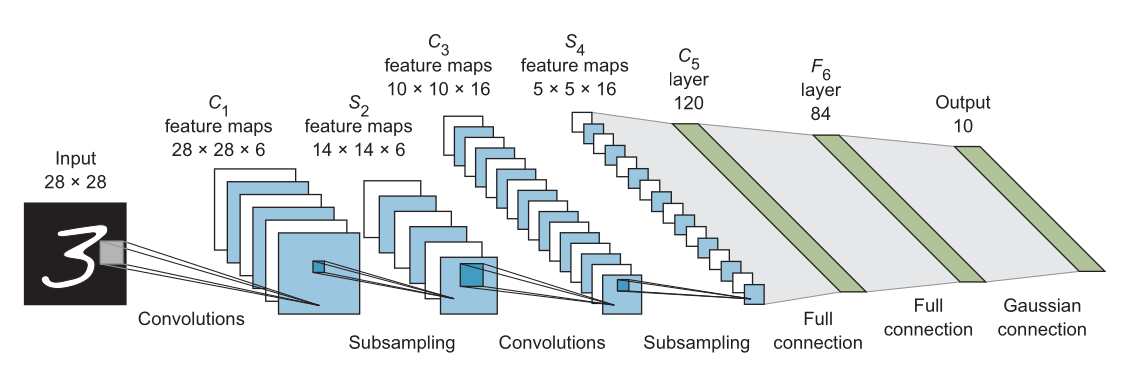

In [3]:
def create_LeNet(input_shape=[28, 28, 1], activation="tanh", pooling_layer=keras.layers.AveragePooling2D):
    """Create a keras sequencial model based on the LeNet-5 architecture"""

    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, activation=activation, input_shape=input_shape, padding="same", name="C1"))
    
    model.add(pooling_layer(pool_size=2, strides=2, padding="valid", name="S2"))

    model.add(keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, activation=activation, padding="valid", name="C3"))

    model.add(pooling_layer(pool_size=2, strides=2, padding="valid", name="S4"))

    model.add(keras.layers.Conv2D(filters=120, kernel_size=5, strides=1, activation=activation, padding="valid", name="C5"))

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(units=84, activation=activation, name="FC6"))
    
    model.add(keras.layers.Dense(units=10, activation="softmax", name="FC7"))

    return model

Noten el uso de la activación `tanh`, hoy en día resulta más común encontrar `relu` o `leaky_relu`, pero en ese entonces los investigadores no habían notado aún las ventajas de estas otras funciones de activación.

Noten también el uso de filtros de 5x5, hoy en día es más común encontrar de 3x3 o más chicos.

In [4]:
LeNet = create_LeNet()

LeNet.summary()

2023-07-02 14:33:26.630833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 S2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 C3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 S4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 C5 (Conv2D)                 (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)               0         
                                                                 
 FC6 (Dense)                 (None, 84)                1

2023-07-02 14:33:26.631049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 14:33:26.631169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 14:33:26.972918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Learning rate scheduler

LeCun y su equipo implementaron un decaimiento de la tasa de aprendizajes, esto es útil como una forma adicional de "frenado", ya que suponemos que al progresar el entrenamiento nos encontramos más cerca del mínimo de la función de pérdida y entonces conviene disminuir el paso para encontrarlo con mejor precisión. Ellos utilizaron un learning rate de:

- 0.0005 por dos épocas
- 0.0002 por las siguientes 3 
- 0.00005 por las siguientes 4 
- 0.00001 para el resto

Entrenaron durante 20 epocas.

Para implementar eso vamos a utilizar un `callback` de keras, esto son funciones especiales que se ejecutan en momentos determinados del loop de aprendizaje, por ejemplo al final de cada época. 

En particular vamos a utilizar `keras.callbacks.LearningRateScheduler`, que al principio de cada época actualiza el valor de la tasa de aprendizaje dependiendo de un cronograma establecido por una función predefinida.

In [5]:
5e-4

0.0005

In [6]:
def lr_schedule(epoch):
    """Return the lr correspondig to the epoch"""
    if epoch <=2:
        lr = 5e-4
    elif epoch <=5:
        lr = 2e-4
    elif epoch <= 9:
        lr = 5e-5
    else:
        lr = 1e-5
    return lr

Text(0.5, 0, 'epoch')

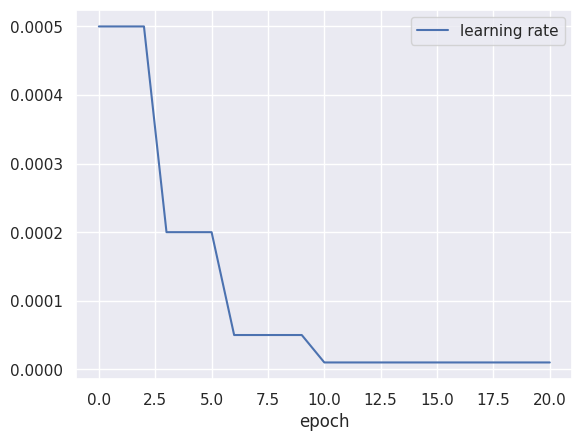

In [7]:
epochs = range(21)
lrs = [lr_schedule(epoch) for epoch in epochs]

ax = sns.lineplot(x=epochs, y=lrs, label="learning rate")
ax.set_xlabel("epoch")

In [8]:
lr_schedureler = keras.callbacks.LearningRateScheduler(lr_schedule)

In [9]:
LeNet.compile(loss="categorical_crossentropy", optimizer="sgd", metrics="accuracy")

In [10]:
# Data loading and preprocessing

(train_data, validation_data), info = tfds.load('mnist', split=["train", "test"], with_info=True, as_supervised=True)

num_classes = 10

def to_categorical(image, label):
    return image, tf.one_hot(tf.cast(label, tf.int32), num_classes)

train_data = train_data.map(to_categorical).cache()
validation_data = validation_data.map(to_categorical).cache()

batch_size = 32

batched_train_data = train_data.shuffle(info.splits["train"].num_examples).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
batched_validation_data = validation_data.shuffle(info.splits["test"].num_examples).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
history = LeNet.fit(
    batched_train_data,
    epochs=20,
    validation_data=batched_validation_data,
    callbacks=[lr_schedureler]
)

Epoch 1/20


2023-07-02 14:33:27.459774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-07-02 14:33:27.460032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-07-02 14:33:29.035564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-02 14:33:29.528352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-02 14:33:2

1863/1875 [============================>.] - ETA: 0s - loss: 1.7092 - accuracy: 0.6327

2023-07-02 14:33:33.469471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-07-02 14:33:33.469742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


1875/1875 [==============================] - 7s 2ms/step - loss: 1.7055 - accuracy: 0.6339 - val_loss: 1.1342 - val_accuracy: 0.8230 - lr: 5.0000e-04
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8796 - accuracy: 0.8365 - val_loss: 0.6853 - val_accuracy: 0.8660 - lr: 5.0000e-04
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6140 - accuracy: 0.8658 - val_loss: 0.5243 - val_accuracy: 0.8869 - lr: 5.0000e-04
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5228 - accuracy: 0.8795 - val_loss: 0.4838 - val_accuracy: 0.8938 - lr: 2.0000e-04
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4858 - accuracy: 0.8858 - val_loss: 0.4499 - val_accuracy: 0.8993 - lr: 2.0000e-04
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4544 - accuracy: 0.8924 - val_loss: 0.4218 - val_accuracy: 0.9042 - lr: 2.0000e-04
Epoch 7/20
1875/1875 [=======================

<Axes: >

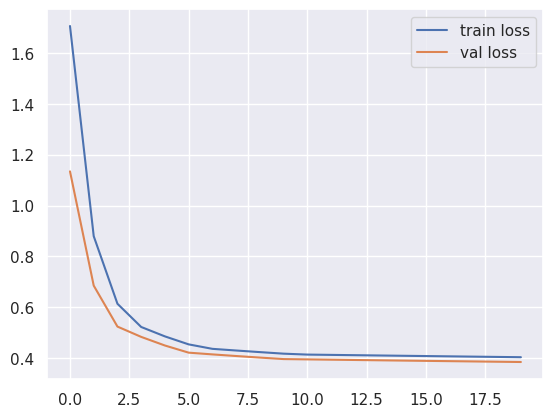

In [12]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label="train loss")
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label="val loss")


<Axes: >

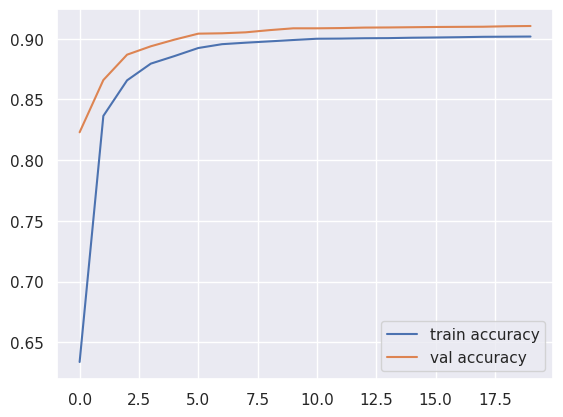

In [13]:
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label="train accuracy")
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label="val accuracy")